# **Turning LLMs into Agentic Systems: <br>Introduction to Tools and Function Calling**

Agents are systems or engines that leverage Large Language Models (LLMs) to perform tasks, make decisions, or interact with users. By harnessing the capabilities of LLMs, these agents can act upon human intent, generate responses, and engage in conversations with both humans and other agents.

Large Language Models (LLMs) are typically used in zero-shot mode, generating output token by token without revision. However, agent workflows can enable iterative document processing or incorporation of external input.

In LLM-powered autonomous agent systems, the LLM acts as the agent's brain, supported by key components:

**Planning**: The agent breaks complex tasks into manageable subgoals and can engage in self-reflection to improve future performance.


**Memory**: Utilizes short-term/in-context learning for immediate task handling. Using long-term memory, the agent is capabable of retening information over extended periods, often using external vector stores for efficient retrieval.


**Tool use**: The agent accesses external APIs for information not present in its training data, such as current events, code execution, or proprietary sources.

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
JINA_API_KEY = userdata.get('JINA_API_KEY')
PASSWORD = userdata.get('APP_PASSWORD')
EMAIL = userdata.get('EMAIL')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.2 MB/s eta 0:00:00


In [3]:
import smtplib

EMAIL = 'abdulraqibshakir03@gmail.com'
APP_PASSWORD = 'password.com0329'

with smtplib.SMTP('smtp.gmail.com', 587) as server:
    server.starttls()
    server.login(EMAIL, APP_PASSWORD)
    server.sendmail(EMAIL, 'recipient@example.com', 'Subject: Test\n\nThis is a test email.')

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
JINA_API_KEY = os.getenv('JINA_API_KEY')
PASSWORD = os.getenv('APP_PASSWORD')
EMAIL = os.getenv('EMAIL')

### **Prerequisites**

Obtain Jina API Key from [here](https://jina.ai/reader/)

Get your Gmail SMTP Password from [here](https://myaccount.google.com/apppasswords)

## **Tool Use & Function Calling**

Tools can be thought of as extensions to Large Language Models (LLMs), enhancing their capabilities much like limbs extend the reach of a body. Tool calling enables an LLM to generate structured output in response to a prompt, adhering to a user-defined schema. Despite its name, tool calling doesn't involve the model actually performing actions.

Instead, the model generates the appropriate arguments for a tool, while the decision to execute the tool and the actual execution itself remain the responsibility of the user.

A tool call includes a name, arguments dict, and an optional identifier. The arguments dict is structured `{argument_name: argument_value}`.


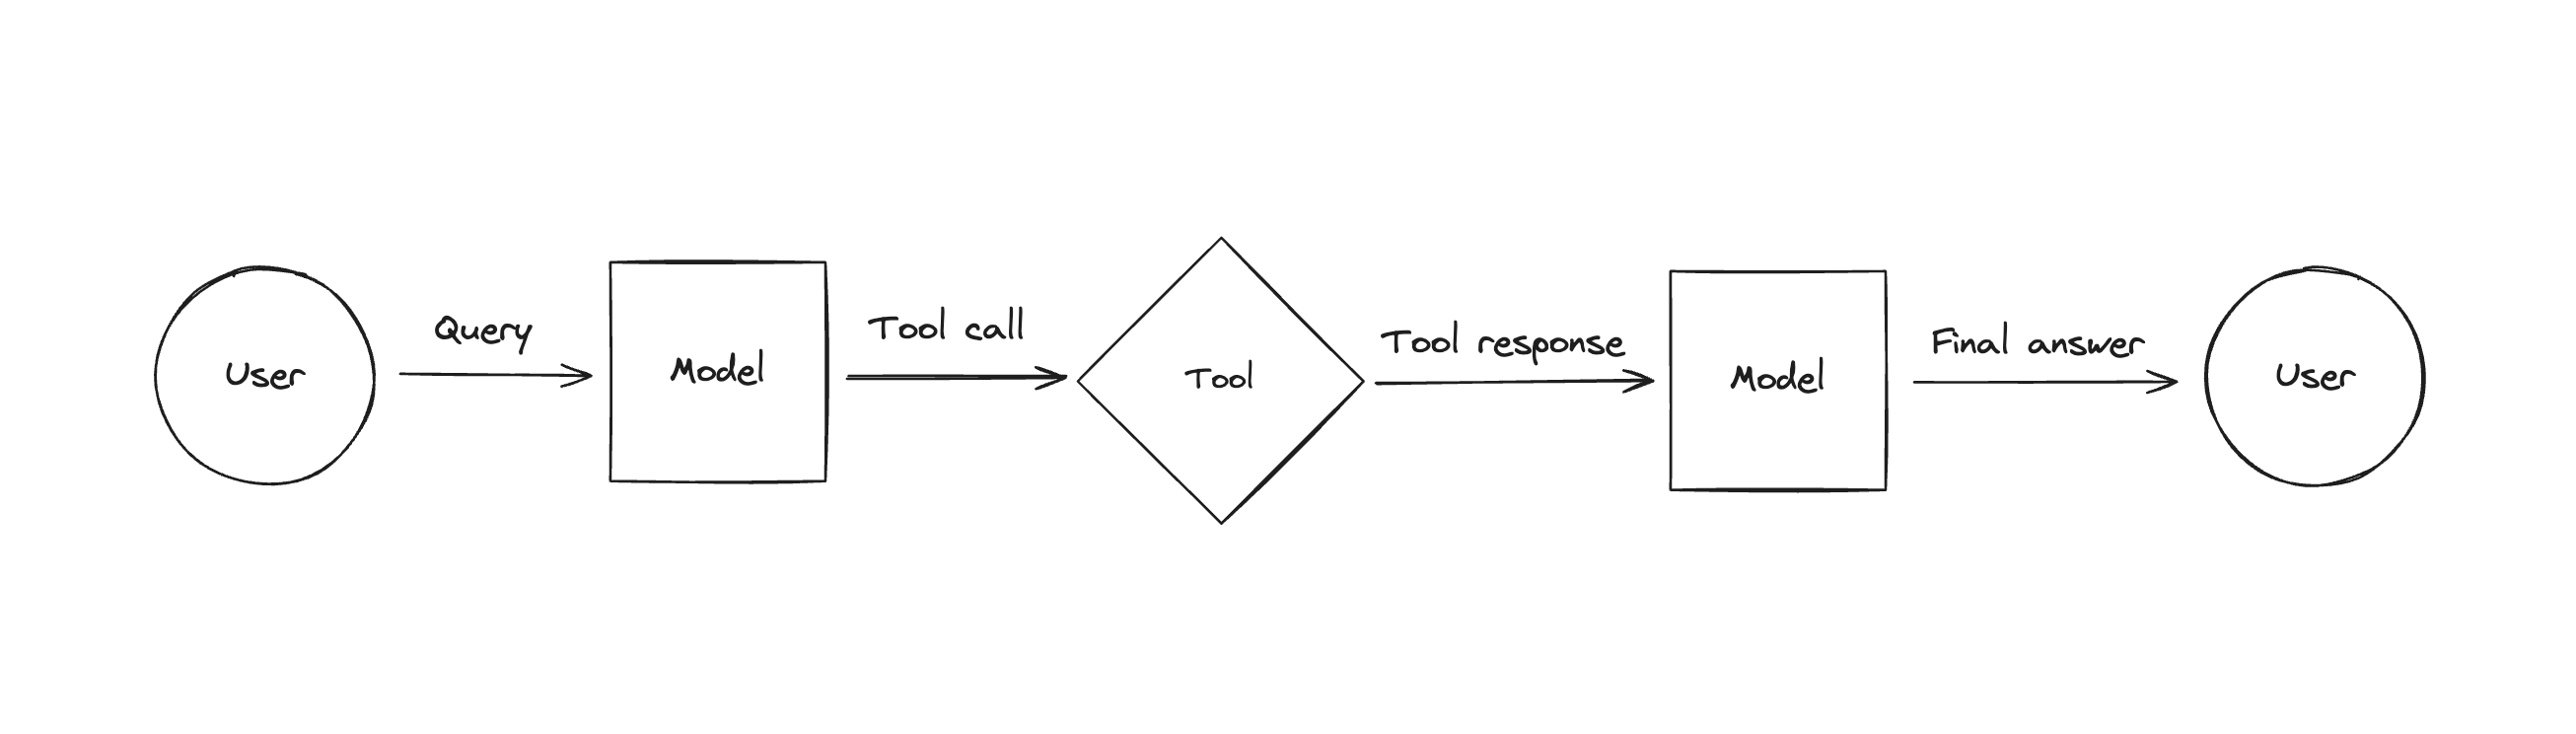

Each LLM family have their structure of defining tools. Here's an example of OpenAI tool structure.

```python
{'type': 'function',
 'function': {'name': 'Search',
  'strict': True,
  'parameters': {'description': 'Use to make a search query.',
   'properties': {'query': {'title': 'Query', 'type': 'string'}},
   'required': ['query'],
   'title': 'Search',
   'type': 'object',
   'additionalProperties': False},
  'description': 'Use to make a search query.'}}
  ```

  Fortunately, libraries like Langchain, LlamaIndex, etc., abstract the creation of tools to support a wide range of model families. Model providers are also contributing by using similar JSON schema structures.

## **Creating Tools with Langchain**

*This part is based on examples from Langchain*

To enable a model to invoke tools, you need to provide the tool schemas when making a chat request. ChatModels in LangChain that support tool invocation offer a `.bind_tools` method. This method takes a list of LangChain tool objects, Pydantic classes, or JSON schemas and associates them with the chat model in the format expected by the provider. Once bound, the tool schemas will be included in every call to the model API.

### **Defining tools with `@tool` decorator**

LangChain's `@tool` decorator simplifies tool creation by automatically handling integration details. Apply this decorator to a function to define a tool with the necessary metadata and configuration, streamlining the process and ensuring proper registration within the LangChain framework.

In [2]:
!pip install langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [4]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


tools = [add, multiply]
tools

[StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'pydantic.v1.main.addSchema'>, func=<function add at 0x7876941be560>),
 StructuredTool(name='multiply', description='Multiplies a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'pydantic.v1.main.multiplySchema'>, func=<function multiply at 0x7876941be5f0>)]

### **Defining tools with Pydantic**

When defining tools with Pydantic, you can create robust and type-safe models that are validated at runtime. These Pydantic models can be easily converted into JSON schemas, which describe the structure and validation rules for the data expected by the tools.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field


# Note that the docstrings here are crucial, as they will be passed along
# to the model along with the class name.
class add(BaseModel):
    """Add two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


class multiply(BaseModel):
    """Multiply two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


tools = [add, multiply]

### **Binding tools with model**

We use the `bind_tools()` method to convert Multiply into a "tool," bind it to the model, and ensure it is passed in each time the model is called, adapting it to the schema required by the model.

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
query = "What is 3 * 12? Also, what is 11 + 49?"

llm_with_tools.invoke(query).tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': 'call_XekRzPnEWm9uzSyQVFZPwaBW',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 11, 'b': 49},
  'id': 'call_tFZQSxigJeAh8CTJModvqmKg',
  'type': 'tool_call'}]

### **Passing the Tool Call Output Back to the Model**

Earlier, we noted that "tool calling doesn't involve the model performing actions directly; instead, the model generates the necessary arguments for a tool, while the decision to execute the tool and the actual execution are handled by the user."

When the output of a tool execution is sent back to the model, LangChain provides the `ToolMessage` class to facilitate this process. The model then uses this output to refine or rephrase its response.

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


tools = [add, multiply]
llm_with_tools = llm.bind_tools(tools)

messages = [HumanMessage(query)]
ai_msg = llm_with_tools.invoke(messages)
messages.append(ai_msg)

for tool_call in ai_msg.tool_calls:
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

messages

[HumanMessage(content='What is 3 * 12? Also, what is 11 + 49?'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gNWktylk64DAz90Uafj6KEcA', 'function': {'arguments': '{"a": 3, "b": 12}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_bUsimjqHQkF9g7CH2NNDfniH', 'function': {'arguments': '{"a": 11, "b": 49}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 113, 'total_tokens': 163}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-efebb173-7155-4deb-a497-149efa40601d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_gNWktylk64DAz90Uafj6KEcA', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'call_bUsimjqHQkF9g7CH2NNDfniH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 113, 'output_tokens': 50, 'total_tokens': 163}),
 ToolMessage(co

## **Building an Agent with Tools**

Develop a newsletter agent that uses content from a website to write the newsletter and send it via email

In [ ]:
from typing import List
from pydantic import BaseModel, Field

class Email(BaseModel):
  subject: str = Field(description="Subject of the email")
  body: str = Field(description="Body of the email")

In [ ]:
import httpx

@tool
def scrape_website(url: str):
  """
  Use to get the text from a website

  Args:
    - url: url to scrape
  """
  headers = {'Authorization': f'Bearer {JINA_API_KEY}'}

  response = httpx.get(f'https://r.jina.ai/{url}', headers=headers)

  return response.text

In [ ]:
import openai
import json

client = openai.OpenAI()

@tool
def write_newsletter(text: str):
  """
  Use to write a newsletter from the provided text

  Args:
    - text: text to write the newsletter from
  """
  completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You're an expert at writing email newsletters. Use the provided context to write a newsletter to a general audience."},
        {"role": "user", "content": f"Context: {text}"},
    ],
   response_format=Email,
)
  return json.dumps(completion.choices[0].message.parsed.dict())


In [ ]:
from email.message import EmailMessage
import smtplib
from email.mime.text import MIMEText


sender = EMAIL
password = PASSWORD

@tool
def send_email(subject: str, body: str, recipients: List[str]):
  """Sends email to multiple users

  Args:
    subject: subject of email
    body: body of the email
    recipients: list of email addresses
  """
  msg = MIMEText(body)
  msg['Subject'] = subject
  msg['From'] = sender
  msg['To'] = ', '.join(recipients)
  with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp_server:
      smtp_server.login(sender, password)
      smtp_server.sendmail(sender, recipients, msg.as_string())
  return "Message sent!"

In [ ]:
tools = [send_email, write_newsletter, scrape_website]
llm_with_tools = llm.bind_tools(tools)

# messages = []
# ai_msg = llm_with_tools.invoke(messages)
# messages.append(ai_msg)

# for tool_call in ai_msg.tool_calls:
#     selected_tool = {"scrape_website": scrape_website, "write_newsletter": write_newsletter, "send_email": send_email}[tool_call["name"].lower()]
#     tool_output = selected_tool.invoke(tool_call["args"])
#     messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

In [ ]:
messages = []

actions = [
    "Get the text from this website https://paulgraham.com/startupideas.html",
    "Write a newsletter from the text",
    "Send an email to okparedave@gmail.com"
]

for action in actions:
  messages.append(HumanMessage(action))
  ai_msg = llm_with_tools.invoke(messages)
  messages.append(ai_msg)

  for tool_call in ai_msg.tool_calls:
    selected_tool = {"scrape_website": scrape_website, "write_newsletter": write_newsletter, "send_email": send_email}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

In [ ]:
messages

[HumanMessage(content='Get the text from this website https://paulgraham.com/startupideas.html'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XUqCTGYXnCeXk6wFKznWYncX', 'function': {'arguments': '{"url":"https://paulgraham.com/startupideas.html"}', 'name': 'scrape_website'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 166, 'total_tokens': 192}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c6d07bd2-657f-493f-86ca-28a03ddfeda5-0', tool_calls=[{'name': 'scrape_website', 'args': {'url': 'https://paulgraham.com/startupideas.html'}, 'id': 'call_XUqCTGYXnCeXk6wFKznWYncX', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 26, 'total_tokens': 192}),
 ToolMessage(content='Title: How to Get Startup Ideas\n\nURL Source: https://paulgraham.com/startupideas.html\n\nMarkdown Content:\n!

### Building Agents without Langchain

In [ ]:
def run_completion(system_prompt, user_prompt, model):
  completion = client.beta.chat.completions.parse(
      model="gpt-4o-mini",
      messages=[
          {"role": "system", "content": system_prompt},
          {"role": "user", "content": user_prompt},
      ],
    response_format=model,
  )
  return completion.choices[0].message.parsed

In [ ]:
from pydantic import BaseModel

class Plan(BaseModel):
  """Use to write a plan of actions to take for given task."""
  actions: List[str] = Field(description="List of actions to take")

In [ ]:
emails = ""

In [ ]:
system_prompt = """
You are an expert at writing newsletters, and your task is to use the given context to write email newsletters and send it to appropriate recipients

These tools are available to you:

- scrape_website: Use to get the text from a website
- write_newsletter: Use to write a newsletter from the provided text
- send_email: Sends email to multiple users
"""

In [ ]:
actions = run_completion("", f"Write a newsletter using text from https://paulgraham.com/startupideas.html and send it to the following emails {emails}", Plan)

In [ ]:
for action in actions.actions:
  print(action)

Create a newsletter template with a catchy subject line.
Visit the provided URL and summarize key points from the article.
Write an engaging introduction to the newsletter that encourages readers to think about startup ideas.
Include a section on the importance of being original in startup ideas, referencing Paul Graham's insights.
Add a section with practical tips on identifying good startup ideas based on the article.
Conclude the newsletter with a call to action, encouraging readers to share their thoughts or startup ideas.
Prepare the email list with the recipients' information.
Proofread the newsletter for any grammatical errors or typos before sending.
Send the newsletter to the provided email addresses.


In [ ]:
emails = []

In [ ]:
steps_to_take = run_completion(system_prompt, f"Write a newsletter using text from https://paulgraham.com/startupideas.html and send it to the following emails {emails}", Plan)

In [ ]:
for action in steps_to_take.actions:
  print(action)

Scrape the website https://paulgraham.com/startupideas.html to extract the relevant text and content.
Compose a newsletter using the extracted text, summarizing key points and insights about startup ideas.
Send the composed newsletter to the specified email recipients.


In [ ]:
messages = []

In [ ]:
class SendEmail(BaseModel):
  """Use to send email to multiple users"""
  subject: str
  body: str


class Newsletter(BaseModel):
  """Use to write a newsletter from the provided text"""
  text: str


class ScrapeWebsite(BaseModel):
  """Use to obtain text from a given url"""
  url: str

In [ ]:
def send_email(subject: str, body: str):
  """Sends email to multiple users

  Args:
    subject: subject of email
    body: body of the email
    recipients: list of email addresses
  """

  msg = MIMEText(body)
  msg['Subject'] = subject
  msg['From'] = sender
  msg['To'] = ', '.join(emails)
  with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp_server:
      smtp_server.login(sender, password)
      smtp_server.sendmail(sender, emails, msg.as_string())
  return "Message sent!"




def write_newsletter(text: str):
  """
  Use to write a newsletter from the provided text

  Args:
    - text: text to write the newsletter from
  """
  completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You're an expert at writing email newsletters. Use the provided context to write a newsletter to a general audience."},
        {"role": "user", "content": f"Context: {text}"},
    ],
   response_format=Email,
)
  return json.dumps(completion.choices[0].message.parsed.dict())




def scrape_website(url: str):
  """
  Use to get the text from a website

  Args:
    - url: url to scrape
  """
  headers = {'Authorization': f'Bearer {JINA_API_KEY}'}

  response = httpx.get(f'https://r.jina.ai/{url}', headers=headers)

  return response.text

In [ ]:
tools = [openai.pydantic_function_tool(SendEmail), openai.pydantic_function_tool(Newsletter), openai.pydantic_function_tool(ScrapeWebsite)]

In [ ]:
def completion(messages, tools):
  response = openai.chat.completions.create(
      model="gpt-4o",
      messages=messages,
      tools=tools,
  )

  return response.choices[0].message

In [ ]:
steps_to_take.actions[0]

'Scrape the website https://paulgraham.com/startupideas.html to extract the relevant text and content.'

In [ ]:
res = completion([{"role": "user", "content": steps_to_take.actions[0]}], tools)

In [ ]:
res

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_DnJDxgEALvnWJijI6FL5bYWe', function=Function(arguments='{"url":"https://paulgraham.com/startupideas.html"}', name='ScrapeWebsite'), type='function')])

In [ ]:
def map_function_call(arguments):
  function_map = {
      "ScrapeWebsite": scrape_website,
      "Newsletter": write_newsletter,
      "SendEmail": send_email
  }

  return function_map[arguments.name](**json.loads(arguments.arguments))


In [ ]:
map_function_call(res)

'Title: How to Get Startup Ideas\n\nURL Source: https://paulgraham.com/startupideas.html\n\nMarkdown Content:\n![Image 1: How to Get Startup Ideas](https://s.turbifycdn.com/aah/paulgraham/how-to-get-startup-ideas-2.gif)\n\nNovember 2012\n\nThe way to get startup ideas is not to try to think of startup ideas. It\'s to look for problems, preferably problems you have yourself.\n\nThe very best startup ideas tend to have three things in common: they\'re something the founders themselves want, that they themselves can build, and that few others realize are worth doing. Microsoft, Apple, Yahoo, Google, and Facebook all began this way.\n\n**Problems**\n\nWhy is it so important to work on a problem you have? Among other things, it ensures the problem really exists. It sounds obvious to say you should only work on problems that exist. And yet by far the most common mistake startups make is to solve problems no one has.\n\nI made it myself. In 1995 I started a company to put art galleries online

In [ ]:
def workflow(messages=[]):
  for action in steps_to_take.actions:
    messages.append({"role": "user", "content": action})
    ai_msg = completion(messages, tools)
    messages.append(ai_msg)
    function_response = map_function_call(ai_msg.tool_calls[0].function)
    messages.append({"role": "tool", "name": ai_msg.tool_calls[0].function.name, "content": function_response, "tool_call_id": ai_msg.tool_calls[0].id})

In [ ]:
workflow()

In [ ]:
messages